In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class NerualNetSignal:
    '''Class for solving the a simple neural net: Finding the frequency of a noisy signal'''
    
    def __init__(self,nHidden,nInX=101,nTrain=100,nRepeat=5):
        
        self.f=[1.,2.,3.,4.] # Possible frequncies in Hz
    
        self.nInX=nInX # Size of the input arrayn
        self.nTrain=nTrain # Number of unique training data
        self.nRepeat=nRepeat # Number of times to repeat training set
        self.nTrain_rep=nTrain*nRepeat # Number of total training sets
        self.nHidden=nHidden # Size of hidden layer
        
        # Set the alpha values
        self.alpha=10./self.nInX
        self.alphaBar=20./self.nHidden # Suggested value from Franklin
        
        # Set up the training set 
        self.xT,self._zT,self.xT_rep,self._zT_rep=self.get_training_set(self.nTrain,self.nRepeat)
        
        # Convert vector outputs to f's
        self.zT=self.get_f_from_zT(self._zT)
        
        # Train the model to get A and B
        self.A,self.B=self.train_neural_net()
        
        # Get the residual and list of final predictions
        self.resid,self.predict=self.get_resid(self.xT,self.zT,self.nTrain)
        
        
    def get_training_set(self,nTrain,nRepeat):
        '''Generate a random training set of nTrain unique input/output pairs repeated nRepeat times.'''

        xT=[]
        zT=[]
        for t in range(nTrain):
            x=np.linspace(0,1,self.nInX)
            f_rand=float(np.random.choice(self.f))
            xi_rand=5.*(2.0*np.random.rand(self.nInX) - 1.0)
            s_t=np.cos(2.*np.pi*f_rand*x)+xi_rand
            xT.append(s_t)
            
            # The output will be an array with a 1 corresponding to f, e.g, [0,1,0,0] => f=2
            f_out=np.zeros(4)
            f_out[int(f_rand-1)]=1.
            zT.append(f_out)
            
        # Duplicate the training set
        xT_rep=xT.copy()
        zT_rep=zT.copy()
        for d in range(nRepeat):
            xT_rep+=xT.copy()
            zT_rep+=zT.copy()
        
        # Shuffle the training set
        _tmp_xz=list(zip(xT_rep,zT_rep))
        random.shuffle(_tmp_xz)
        xT_rep,zT_rep=zip(*_tmp_xz)
        
        return xT,zT,xT_rep,zT_rep    
    
    def train_neural_net(self):
        '''Train the neural network'''
        
        # Tolerance and step size for convergence of the steepest descent
        tol=1e-3
        eta=0.1
        
        # Randomly initialize A and B matrix
        A=np.random.rand(len(self.f),self.nHidden)
        B=np.random.rand(self.nHidden,self.nInX)
    
        for k in range(self.nTrain_rep):

            yk=self._zT_rep[k]
            z_tilde=self.g(self.alpha,np.dot(B,self.xT_rep[k]))-0.5
            zk=self.g(self.alphaBar,np.dot(A,z_tilde))

            nConv=0 # Keep track of number of steps to convergence
            while(np.dot((zk-yk),(zk-yk)) > tol):
                
                sigma=2*self.alphaBar*(zk-yk)*zk*(1.-zk) # 1x4 array
                delA=np.outer(sigma,z_tilde)

                sigma_tilde=self.alpha*(0.5+z_tilde)*(0.5-z_tilde) # 1 x nHidden array
                delB=np.outer(np.dot(sigma,A)*sigma_tilde,self.xT_rep[k])
                
                A-=eta*delA
                B-=eta*delB
                
                z_tilde=self.g(self.alpha,np.dot(B,self.xT_rep[k]))-0.5
                zk=self.g(self.alphaBar,np.dot(A,z_tilde))
                
                # Limit to 10000 steps. For lower k, runs into convergence issues
                nConv+=1
                nThresh=10000
                if nConv > nThresh:
                    print('WARNING: Trouble converging A and B matricies, stopped after',nThresh,'cycles.')
                    break

        return A,B
    
    def g(self,alpha,x):
        '''Sigmoid Nonlinear function'''
        return 1/(1+np.exp(-alpha*x))
    
    def apply(self,x):
        '''Apply the nerual net to some input x'''
        z_tilde=self.g(self.alpha,np.dot(self.B,np.array(x)))-0.5
        zk=self.g(self.alphaBar,np.dot(self.A,z_tilde))
        return zk
    
    def get_f_from_zT(self,zT):
        '''Convert the vector to a given f'''
        fs=[]
        for z in zT:
            fs.append(np.dot(z,self.f))
        return fs
    
    def get_resid(self,xT,zT,nData):
        '''Get the residual of some set of data'''
        
        resid=[]
        predict=[]
        for x in range(nData):
            
            # Get the predictions, convert to f
            gAx=self.apply(xT[x])
            pred=self.get_f_from_zT([gAx])
            predict.append(pred)

            # Calculate the residual
            resid.append(np.abs(pred-zT[x]))
    
        resid=np.ndarray.flatten(np.array(resid))
        
        return resid,predict
    
    def new_data_set(self,nData):
        '''Test our model on a new set of data (same size as training data)'''
        
        xTnew,_zTnew,xTnew_rep,_zTnew_rep=self.get_training_set(nData,1)
        zTnew=self.get_f_from_zT(_zTnew)
        
        newResid,newPredict=self.get_resid(xTnew,zTnew,nData)
        
        return xTnew,zTnew,newResid,newPredict
    

In [14]:
# Set up and train the neural network
nHidden=8
nn=NerualNetSignal(nHidden)

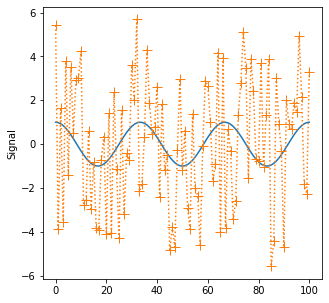

In [15]:
# Plot an example
fig,ax=plt.subplots(figsize=(5,5))

x=np.linspace(0,1,101)
ax.plot(np.cos(2.*np.pi*nn.zT[0]*x),'-')

ax.plot(nn.xT[0],'+:',Markersize=10)
ax.set_ylabel('Signal')

plt.savefig('signal_example.pdf',bbox_inches='tight')
plt.show()

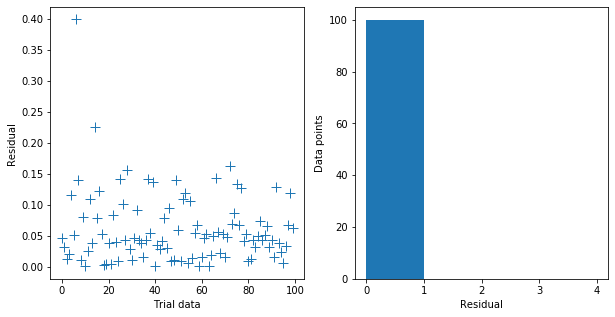

In [16]:
# Test to see that the training was perfomed correctly by plotting the residuals of the training set
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.plot(np.array(nn.resid),'+',Markersize=10)
ax1.set_xlabel('Trial data')
ax1.set_ylabel('Residual')

ax2.hist(np.abs(np.array(nn.resid)),bins=[0,1,2,3,4])
ax2.set_xlabel('Residual')
ax2.set_ylabel('Data points')


plt.savefig('signal_resid_k'+str(nHidden)+'.pdf',bbox_inches='tight')
plt.show()

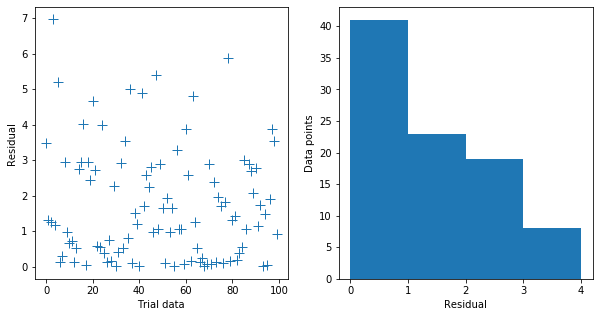

In [17]:
# Apply to some new data
xTnew,zTnew,newResid,newPredict=nn.new_data_set(100)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.plot(np.array(newResid),'+',Markersize=10)
ax1.set_xlabel('Trial data')
ax1.set_ylabel('Residual')

ax2.hist(np.abs(np.array(newResid)),bins=[0, 1, 2, 3,4])
ax2.set_xlabel('Residual')
ax2.set_ylabel('Data points')


plt.savefig('signal_new_k'+str(nHidden)+'.pdf',bbox_inches='tight')
plt.show()

In [ ]:
# Lets try taking the FFT of the dataset
fft_signal=np.fft.rfft(nn.xT[0])

fig,ax=plt.subplots(figsize=(5,5))
ax.plot(fft_signal.imag,'+:',Markersize=10)

ax.set_ylabel('FFT of Signal')

plt.savefig('signal_example_fft.pdf',bbox_inches='tight')
plt.show()